# Multiple Query PRM APF Planner

Importing all required libraries and defining all required variables

In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# The map is 60 x 40
map = np.zeros((60, 40))
# Nodes can be denoted by 1s and obstacles (all the cells in the area) by 0s


Setting up the plot and populating it with obstacles

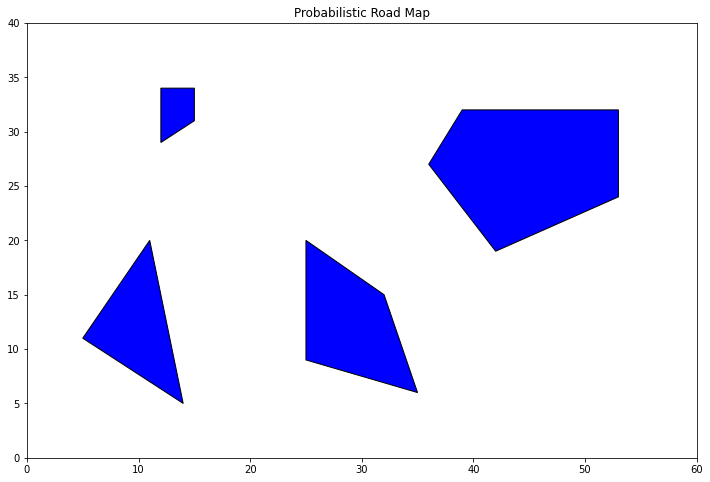

In [7]:
plt.rcParams['figure.figsize'] = (12, 8)
x = np.linspace(0, 60, 10)
y = np.linspace(0, 40, 10)
fig,ax = plt.subplots()

ax.set_title('Probabilistic Road Map')

with open("obstacles.txt") as f:
    for line in f:
        coord_arr = []
        vertices_arr = line.split()
        # join each 2 consecutive values and form an array of coordinates
        for i in range(0, len(vertices_arr), 2):
            coord_arr.append((int(vertices_arr[i]), int(vertices_arr[i+1])))
        p = Polygon(coord_arr, facecolor = 'blue', edgecolor = 'black')
        ax.add_patch(p)
        ax.set_xlim([0, 60])
        ax.set_ylim([0, 40])
        #plt.fill(vertices_arr[::2], vertices_arr[1::2])

Defining the following functions: 
- `dist()`: to judge the distance between two nodes.\
Since we just need a metric to evaluate the distance between two nodes, we can skip the square root calculation.
- `knn()`: to find the k nearest neighbors of a node.


In [3]:
def dist(q1,q2):
    return (q1[0]-q2[0])**2 + (q1[1]-q2[1])**2

def knn(q,Q,k):
    dists = [dist(q,p) for p in Q if p != q]
    return [Q[i] for i in np.argsort(dists)[:k]]


Populating the grid with configurations

In [4]:
# A list of coordinates that are chosen randomly 
N_nodes = 1000
Q = [(np.random.rand()*60, np.random.rand()*40) for _ in range(N_nodes)]



## Checkpoint 1: 
Construct the roadmap and show the graph on matplotlib. Show the sampled nodes in green, nodes that were rejected as red, obstacles as blue. Also connect the nodes that share a edge using straight lines.

In [9]:

for point in Q:
    ax.scatter(point[0],point[1],c=0,s=1)

#! Use APF to join the nodes that can be joined together




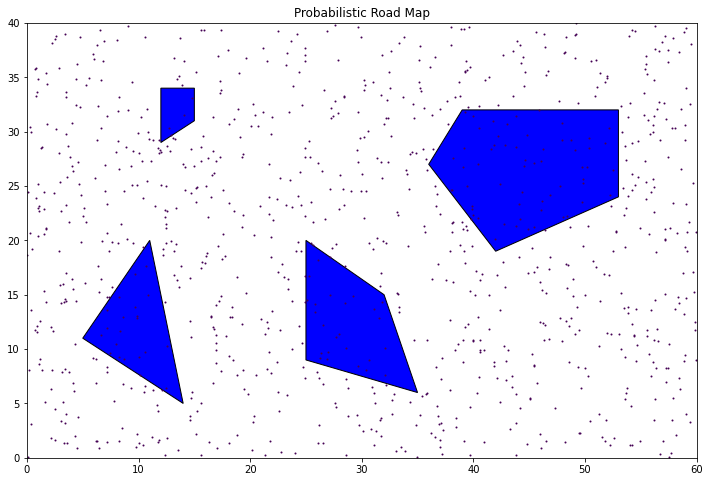

In [10]:
fig

## Checkpoint 2:
Augment the start and the goal point to the roadmap. Mark these points using a separate color. Show the graph on matplotlib again as described above. Then apply Dijkstra or A∗ search to find a path from the start to the goal point. Mark the edges that constitute the path in some other color. Repeat for all queries in the file

## Checkpoint 3:
Divide the map into a grid (each square should be of 0.0625 sq units) and show it (use any method you want, we just want to look at it). Mark a grid square as blocked if it’s centre lies inside an obstacle. Else mark it free. Color all blocked grid square as black, rest as white. (Do all this in a separate image/plot, don’t make the previous plot cluttered).

## Checkpoint 4: 
Apply Brushfire or the Wavefront Planner and find out the distances of each grid square from the obstacles. Use these distances for planning a path locally. Create an animation, or mark the path in the grid.